# Reading in file and converting timestamps

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import compress

from datetime import datetime
from dateutil.parser import parse

import math
import os
import copy
import pickle

import drugLookup

In [2]:
# Read in data (from pickle file)
file = open('drug_data','rb')
drug_data = pickle.load(file)

# Remove not_drugs

In [3]:
def isDrug(categoryList):
    return('not_drugs' not in categoryList)
row_is_drug = drug_data['drug_prediction'].apply(isDrug)
drug_data = drug_data[row_is_drug]

In [4]:
drug_data.shape

(79813, 6)

# Get listings with only one category

In [5]:
# Count categories for each listing
print('Count number of labels for each listing:')
print(drug_data['drug_prediction'].apply(len).groupby(drug_data['drug_prediction'].apply(len)).count())

Count number of labels for each listing:
drug_prediction
0     9214
1    67880
2     2678
3       41
Name: drug_prediction, dtype: int64


In [6]:
# Get listings with fewer than 1 category
cond1 = drug_data['drug_prediction'].apply(len) < 2
cond2 = drug_data['drug_prediction'].apply(len) > 0
drug_df = copy.deepcopy(drug_data[cond1 & cond2])

# Get first string in one element list of strings
# Input: list of strings
def getFirst(mylist):
    return(mylist[0])
drug_df['drug_prediction'] = drug_df['drug_prediction'].apply(getFirst)

# Summary statistics (before filtering)

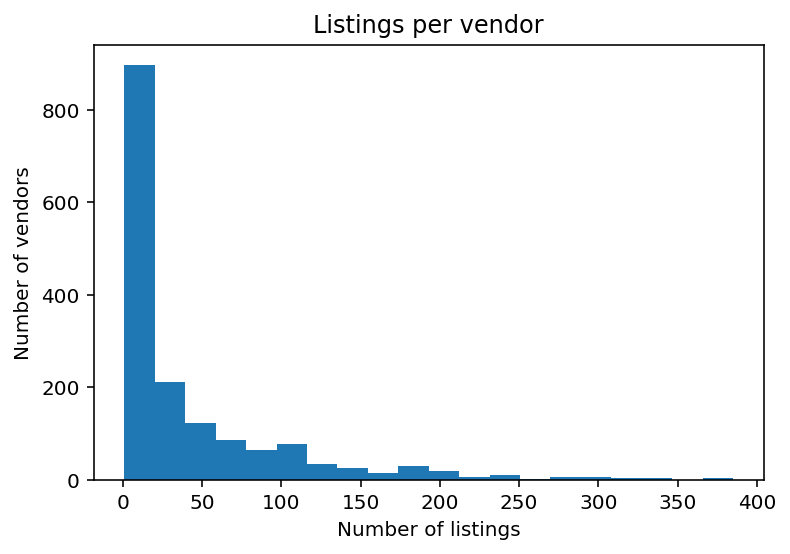

In [7]:
# Count number of listings for each vendor and create histogram
sales_by_vendor = drug_df['vendor_name'].groupby(drug_df['vendor_name']).count() #changed from drug_df to alldrugs
plt.hist(sales_by_vendor, bins = 20)
plt.xlabel('Number of listings')
plt.ylabel('Number of vendors')
plt.title('Listings per vendor')
plt.show()

In [8]:
# Get list of vendors in dataframe
_ , vendor_list = pd.factorize(drug_df['vendor_name'])

# Function to count number of drugs per vendor
def countDrugsForVendor(vendor_name):
    return(len(drug_df[drug_df['vendor_name'] == vendor_name].groupby('drug_prediction').count().index))

# Get number of drugs sold for each vendor
vendor_drug_counts = {vendor : countDrugsForVendor(vendor) for vendor in vendor_list}

# Make histogram of vendor_drug_counts
#bins = range(1,max(vendor_drug_counts.values()))
#plt.hist(vendor_drug_counts.values(), bins = bins)
#plt.xlabel('Number of drug categories')
#plt.ylabel('Number of vendors')
#plt.title('Categories per vendor')
#plt.show()

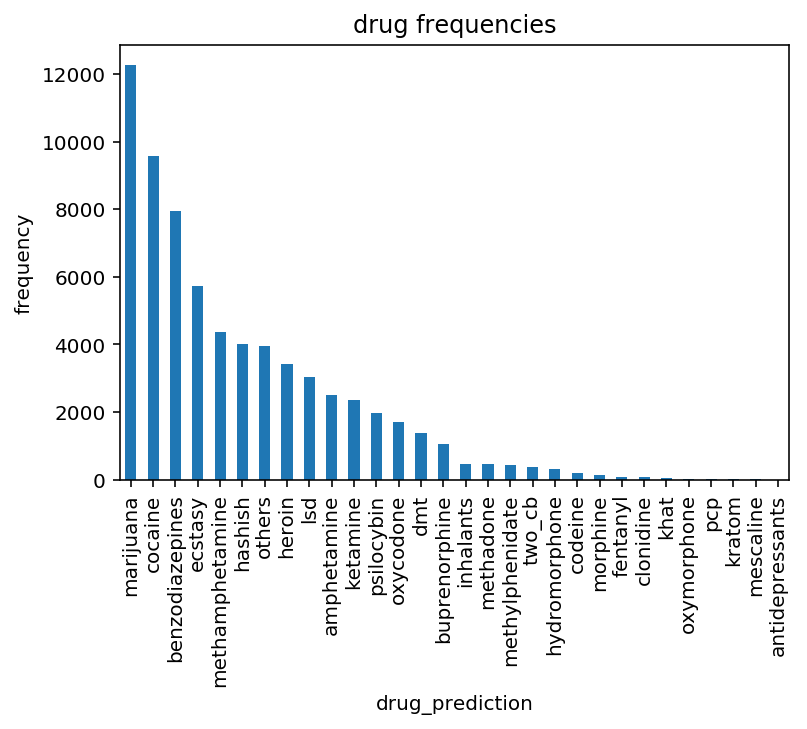

In [9]:
# Show percentage of each drug after filtering
drug_counts = drug_df['drug_prediction'].groupby(drug_df['drug_prediction']).count().sort_values(ascending = False)
100*drug_counts/np.sum(drug_counts)

# Plot results
drug_counts.plot(kind = 'bar')
plt.ylabel('frequency')
plt.title('drug frequencies')
plt.show()

# Filter out low frequency drugs

drug_prediction
marijuana          18.05
cocaine            14.08
benzodiazepines    11.72
ecstasy             8.42
methamphetamine     6.45
hashish             5.90
others              5.84
heroin              5.03
lsd                 4.49
amphetamine         3.67
ketamine            3.46
psilocybin          2.92
oxycodone           2.52
dmt                 2.04
buprenorphine       1.53
inhalants           0.67
methadone           0.67
methylphenidate     0.65
two_cb              0.54
hydromorphone       0.45
codeine             0.29
morphine            0.22
fentanyl            0.12
clonidine           0.10
khat                0.08
oxymorphone         0.04
pcp                 0.02
kratom              0.01
mescaline           0.01
antidepressants     0.00
Name: drug_prediction, dtype: float64


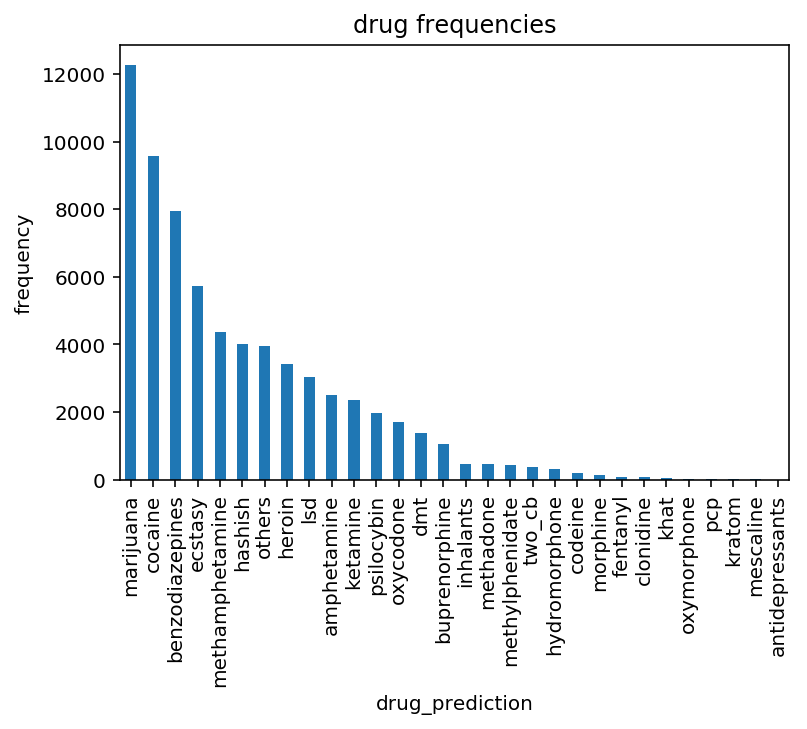

In [10]:
# Plot drug categories by popularity
drug_counts = drug_df['drug_prediction'].groupby(drug_df['drug_prediction']).count().sort_values(ascending = False)
drug_percents = round(100 * drug_counts/np.sum(drug_counts),2)

# For each drug, get percentage of the whole
print(drug_percents)

# Plot results
drug_counts.plot(kind = 'bar')
plt.ylabel('frequency')
plt.title('drug frequencies')
plt.show()

In [11]:
# Function checks if item is in the set
def isInSet(item, myset):
    return(item in myset)

# Get percentages for each drug
hi_freq_drugs = drug_percents[drug_percents > 1].index # Get names of drugs

# Check if row is high-frequency drug
is_hi_freq_row = drug_df['drug_prediction'].apply(isInSet, myset = hi_freq_drugs)
drug_df = drug_df[is_hi_freq_row]

# Show percentage of each drug after filtering
drug_counts2 = drug_df['drug_prediction'].groupby(drug_df['drug_prediction']).count().sort_values(ascending = False)
100*drug_counts2/np.sum(drug_counts2)

drug_prediction
marijuana          18.777105
cocaine            14.650218
benzodiazepines    12.193702
ecstasy             8.761014
methamphetamine     6.706000
hashish             6.140526
others              6.074630
heroin              5.230251
lsd                 4.672439
amphetamine         3.821929
ketamine            3.599724
psilocybin          3.034250
oxycodone           2.618956
dmt                 2.123975
buprenorphine       1.595280
Name: drug_prediction, dtype: float64

# Distribution of sales among vendors

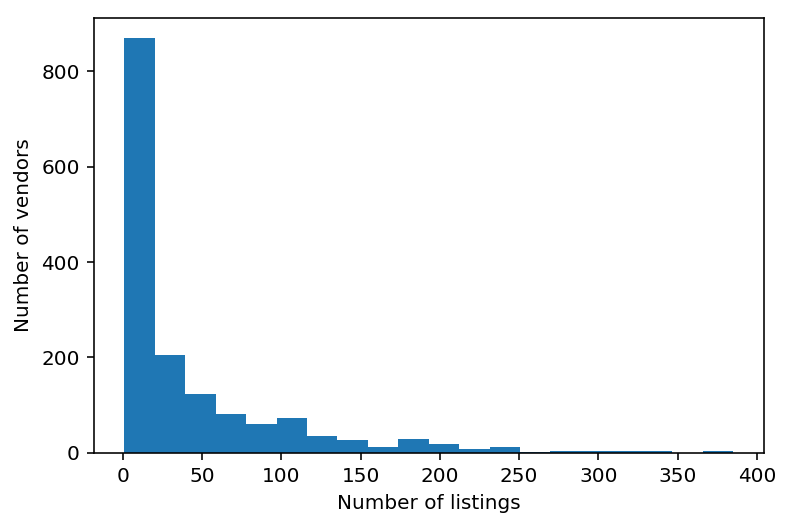

In [12]:
# Count number of listings for each vendor and create histogram
sales_by_vendor = drug_df['vendor_name'].groupby(drug_df['vendor_name']).count() #alldrugs changed from drug_df
plt.hist(sales_by_vendor, bins = 20)
plt.xlabel('Number of listings')
plt.ylabel('Number of vendors')
plt.show()


In [13]:
# Sort vendors by number of sales
sorted_sales_by_vendor = sales_by_vendor.sort_values(ascending = False)
at_least_100_sales = np.where(sorted_sales_by_vendor == 100)[0][-1]
at_least_50_sales = np.where(sorted_sales_by_vendor == 50)[0][-1]
at_least_20_sales = np.where(sorted_sales_by_vendor == 20)[0][-1]

In [14]:
# Get cumulative sum of series
cumulative_sales = [np.sum(sorted_sales_by_vendor[:i]) for i in range(len(sorted_sales_by_vendor))]

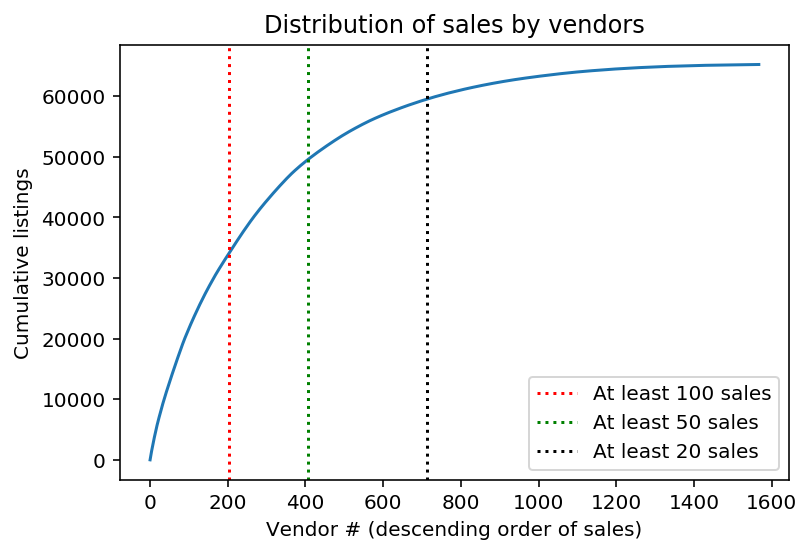

In [15]:
# Plot number of vendors vs. number of listings
plt.plot(cumulative_sales)
plt.axvline(x=at_least_100_sales, color = 'r',linestyle = ':', label = 'At least 100 sales')
plt.axvline(x=at_least_50_sales, color = 'g',linestyle = ':', label = 'At least 50 sales')
plt.axvline(x=at_least_20_sales, color = 'k',linestyle = ':', label = 'At least 20 sales')
plt.xlabel('Vendor # (descending order of sales)')
plt.ylabel('Cumulative listings')
plt.title('Distribution of sales by vendors')
plt.legend()
plt.show()

# Thresholding out low-frequency vendors

In [16]:
# Threshold out vendors with less than given threshold of listings
thresh = 100
hi_freq_vendors = sales_by_vendor[sales_by_vendor > thresh]
print('Vendors before thresholding:', len(sales_by_vendor))
print('Vendors after thresholding:', len(hi_freq_vendors))

Vendors before thresholding: 1568
Vendors after thresholding: 191


In [17]:
#Calculate the ratio of listings for vendors > threshold
percentage_of_listings = np.sum(hi_freq_vendors)/np.sum(sales_by_vendor)
percent_of_vendors = len(hi_freq_vendors)/len(sales_by_vendor)
print('Percent of listings:',percentage_of_listings)
print('Percent of vendors :',percent_of_vendors)

Percent of listings: 0.5039154087809363
Percent of vendors : 0.12181122448979592


In [18]:
# Mean number of drugs per vendor
avg_sales = sum(sales_by_vendor)/len(hi_freq_vendors)
avg_sales

341.64921465968587

In [19]:
# Function checks if item is in the set
def isInSet(item, myset):
    return(item in myset)

hi_freq_vendor_names = list(hi_freq_vendors.index)

# For every row, check if the vendor is in high-frequency set
is_hi_freq_row = drug_df['vendor_name'].apply(isInSet, myset = hi_freq_vendors.index)

# Get dataframe with just the high-frequency set
drug_df = drug_df[is_hi_freq_row]

Now analyze distribution for thresholded dataframe

# Count categories per vendor

Plot number of drugs sold per vendor (histogram)

In [20]:
# Get list of vendors in dataframe
_ , vendor_list = pd.factorize(drug_df['vendor_name'])

# Function to count number of drugs per vendor
def countDrugsForVendor(vendor_name):
    return(len(drug_df[drug_df['vendor_name'] == vendor_name].groupby('drug_prediction').count().index))

# Get number of drugs sold for each vendor
vendor_drug_counts = {vendor : countDrugsForVendor(vendor) for vendor in vendor_list}

# Summary statistics (after filtering)

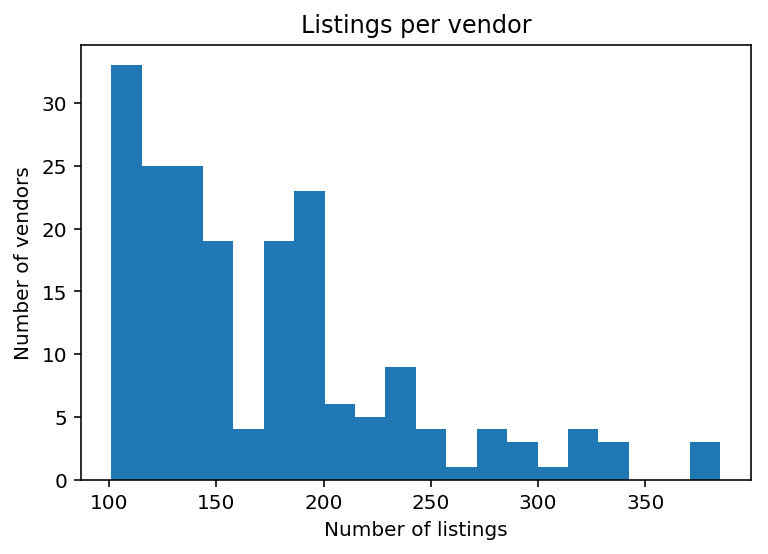

Mean  : 172.2
Median: 155.0
Max   : 385
Min   : 101


In [21]:
# Count number of listings for each vendor and create histogram
sales_by_vendor = drug_df['vendor_name'].groupby(drug_df['vendor_name']).count() #changed from drug_df to alldrugs
plt.hist(sales_by_vendor, bins = 20)
plt.xlabel('Number of listings')
plt.ylabel('Number of vendors')
plt.title('Listings per vendor')
plt.show()

print('Mean  :', round(np.mean(sales_by_vendor),1))
print('Median:', round(np.median(sales_by_vendor),1))
print('Max   :', round(np.max(sales_by_vendor),1))
print('Min   :', round(np.min(sales_by_vendor),1))

In [22]:
print('Mean  :', round(np.mean(list(vendor_drug_counts.values())),1))
print('Median:', round(np.median(list(vendor_drug_counts.values())),1))
print('Max   :', round(np.max(list(vendor_drug_counts.values())),1))
print('Min   :', round(np.min(list(vendor_drug_counts.values())),1))

# Make histogram of vendor_drug_counts
#bins = range(1,max(vendor_drug_counts.values()))
#plt.hist(vendor_drug_counts.values(), bins = bins)
#plt.xlabel('Number of drug categories')
#plt.ylabel('Number of vendors')
#plt.title('Categories per vendor')
#plt.show()

Mean  : 1.5
Median: 1.0
Max   : 4
Min   : 1


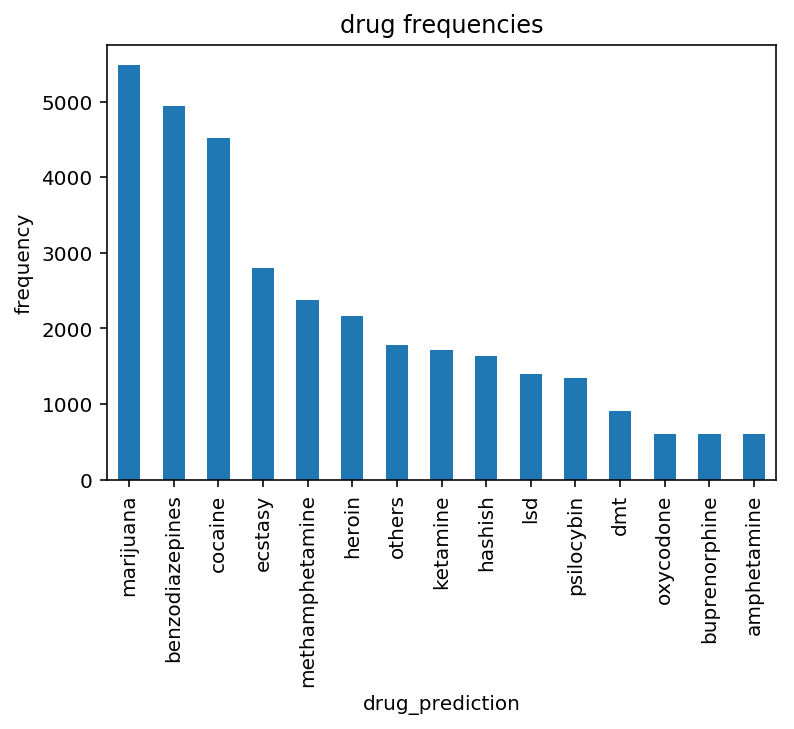

In [23]:
# Show percentage of each drug after filtering
drug_counts = drug_df['drug_prediction'].groupby(drug_df['drug_prediction']).count().sort_values(ascending = False)
100*drug_counts/np.sum(drug_counts)

# Plot results
drug_counts.plot(kind = 'bar')
plt.ylabel('frequency')
plt.title('drug frequencies')
plt.show()

## Rebuild dataset for HMM model

In [24]:
# Sort data by date
drug_df_sorted = drug_df.sort_values(by = 'date')
# drug_df_sorted = drug_df_sorted[drug_df_sorted['date'] > datetime(2018,10,1)]

# Get total number of samples, and number of train/test samples
n_samples = drug_df_sorted.shape[0]
n_train = round(n_samples * .75)

# Create training/test set
train_set = drug_df_sorted.iloc[:n_train,[2,4,5]]
test_set = drug_df_sorted.iloc[n_train:,[2,4,5]]

print('Total number of samples', n_samples)
print('Train samples          ', n_train)
print('Test samples            ', n_samples - n_train)

Total number of samples 32883
Train samples           24662
Test samples             8221


In [25]:
# Remove all samples from train set which are not in the test set
_ , train_vendors = pd.factorize(train_set['vendor_name'])
_ , test_vendors = pd.factorize(test_set['vendor_name'])

In [26]:
# Get intersection of train and test vendors
# Only include these in the dataset
vendors_in_both = train_vendors.intersection(test_vendors)
print(set(train_vendors).symmetric_difference(set(test_vendors)))
print(set(test_vendors).symmetric_difference(set(train_vendors)))
print('airforceone' in train_vendors)
print('airforceone' in test_vendors)
print(len(train_vendors))
print(len(test_vendors))

{'airforceone'}
{'airforceone'}
True
False
191
190


In [27]:
# Take out airforceone from training and test set 
train_set_filtered = train_set[train_set['vendor_name'] != 'airforceone']
test_set_filtered = test_set[test_set['vendor_name'] != 'airforceone']

In [44]:
import pickle
file = open('train_set','wb')
pickle.dump(train_set, file)
file.close()

file = open('test_set','wb')
pickle.dump(test_set, file)
file.close()

In [28]:
# Check that there are no vendors who are not in both training and testing sets
_ , train_vendors_filtered = pd.factorize(train_set_filtered['vendor_name'])
_ , test_vendors_filtered = pd.factorize(test_set_filtered['vendor_name'])

print(set(train_vendors_filtered).symmetric_difference(set(test_vendors_filtered)))
print(set(test_vendors_filtered).symmetric_difference(set(train_vendors_filtered)))
print('airforceone' in train_vendors_filtered)
print('airforceone' in test_vendors_filtered)
print(len(train_vendors_filtered))
print(len(test_vendors_filtered))

set()
set()
False
False
190
190


In [63]:
test_set_filtered.head()

,vendor_name,date,drug_prediction
53463,DerSandmann,2018-12-01 22:15:22,cocaine
15112,pillonpourvousservir,2018-12-01 22:17:51,hashish
15154,pillonpourvousservir,2018-12-01 22:17:51,hashish
55014,PHARMALABS,2018-12-01 22:27:33,others
15864,Gladyman,2018-12-01 22:29:13,others


In [64]:
a = [1,2,3,4,5]
a[-4:]

[2, 3, 4, 5]

In [29]:
def dataset_reshape(dataset, rows, cols):
    # 按顺序截取部分数据，然后重塑形状。
    dataset_ = dataset[0 : int(rows*cols)]
    return dataset_.reshape((rows, cols))

n_train = 5
n_test = 1
len_seq = 100


v_train = np.array(train_set_filtered['vendor_name'][-n_train*len_seq:])
d_train = np.array(train_set_filtered['drug_prediction'][-n_train*len_seq:])
v_test = np.array(test_set_filtered['vendor_name'][:n_test*len_seq])
d_test = np.array(test_set_filtered['drug_prediction'][:n_test*len_seq])

# Reshape for model
v_train = v_train.reshape((n_train,len_seq))
d_train = d_train.reshape((n_train,len_seq))
v_test = v_test.reshape((n_test,len_seq))
d_test = d_test.reshape((n_test,len_seq))


In [31]:
print(v_train.shape,\
d_train.shape,\
v_test.shape,\
d_test.shape)

(5, 100) (5, 100) (1, 100) (1, 100)


In [25]:
# 将数据集分割为训练集和测试集
def dataset_split(dataset):
    # Input dataset and split it into training set and testing set.
    # 分割方法：将test_date里月份的样本放进测试集，其余放进训练集。
    # input format: 35606 x 3
    # 201812~201901的交易量为7585，占比27%；
    test_date = ['2018-12', '2019-01']
    v_train, v_test = [], []
    d_train, d_test = [], []
    for i in range(len(dataset)):
        if dataset[i][0] in test_date:
            d_test.append(dataset[i][1])
            v_test.append(dataset[i][2])
        else:
            d_train.append(dataset[i][1])
            v_train.append(dataset[i][2])
    return np.array(v_train), np.array(v_test), np.array(d_train), np.array(d_test)

def dataset_reshape(dataset, rows, cols):
    # 按顺序截取部分数据，然后重塑形状。
    dataset_ = dataset[0 : int(rows*cols)]
    return dataset_.reshape((rows, cols))


if __name__ == '__main__':
    # 参数初始化
    n_train = 280
    n_test = 75
    len_seq = 100

    # 分割数据集
    v_train_, v_test_, d_train_, d_test_ = dataset_split(data_DDV)
    # len(train) = 28021; len(test) = 7585

    # 重塑形状（v_train, d_train, v_test, d_test）
    v_train = dataset_reshape(v_train_, n_train, len_seq) # size = n_train x len_seq
    d_train = dataset_reshape(d_train_, n_train, len_seq)
    v_test = dataset_reshape(v_test_, n_test, len_seq) # size = n_test x len_seq
    d_test = dataset_reshape(d_test_, n_test, len_seq)


# Emission Probability Table

In [32]:
# Factorize drug_predictions
_ , uniques = pd.factorize(train_set_filtered['drug_prediction'])

In [33]:
# Function gets tally of drugs sold for given vendor
def getDrugsForVendor(vendor_name):
#     Args: Name of a vendor (string)
#     Returns: series, representing proportion of total for each drug
    vendor_subset = drug_df[drug_df['vendor_name'] == vendor_name]
    vendor_drug_tally = vendor_subset['drug_prediction'].groupby(vendor_subset['drug_prediction']).count()
    return(vendor_drug_tally/np.sum(vendor_drug_tally))

In [34]:
# Get list of vendors in the data frame
_ , vendor_list = pd.factorize(train_set_filtered['vendor_name'])

In [35]:
#Create emission probability dataframe
emission_prob_table = pd.DataFrame(columns = uniques)

#Insert vendor name column
emission_prob_table.insert(0, "Vendor Name", vendor_list)

# Apply function to dataframe
emission_prob_table.iloc[:,1:] = emission_prob_table['Vendor Name'].apply(getDrugsForVendor)

In [36]:
# Sort by Vendor name and fill NA values with 0
emission_prob_table = emission_prob_table.sort_values(by = ['Vendor Name'])
emission_prob_table = emission_prob_table.fillna(0)

emission_prob_table

,Vendor Name,ketamine,methamphetamine,heroin,cocaine,dmt,lsd,others,benzodiazepines,ecstasy,hashish,buprenorphine,oxycodone,marijuana,psilocybin,amphetamine
145,24-7SmokeShop,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000
38,420HighStreet,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000
65,9incecloud,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
36,A1CRACK,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
140,Alagbada726,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.551136,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.448864
42,AlanCuring420_UK,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.022814,0.000000,0.0,0.977186,0.0,0.000000
25,Americansteroids,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
148,Aphelion,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
89,BlackSheepSquadron,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000
119,Boliko,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [31]:
# sales_by_vendor = drug_df['vendor_name'].groupby(drug_df['vendor_name']).count()
# sales_by_vendor.sort_values(ascending=False)
# np.sum(sales_by_vendor)

35606

In [32]:
# emission_prob_table.to_csv('emission_prob_table_1.csv', index = False)

In [37]:
# shift the emission_prob_table (dataframe) to array format
ems_prob = np.array(emission_prob_table)[:,1:]
ems_prob = np.array(list(ems_prob[:, :]), dtype=np.float) # convert to float
ems_prob.shape

(190, 15)

## Build HMM models to estimate parameters and predict hidden state

In [38]:
from itertools import groupby
from operator import itemgetter
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder

In [39]:
# 使用Baum-Welch算法来估计参数，然后使用Viterbi算法来预测隐状态数列。

def hmm_BaumWelch(data, n_states, n_iter=100, n_train=10):
    """
    @ parameters:
        data (matrix): The encoded observed sequence of hidden state
        n_states (int): The length of sequence for hidden state. 
        n_iter (int): The iteration of hmm.MultinomialHMM.
        n_train (int): The training times.
    @ return:
        start_prob (list): Start probability with size = 1 x n_states.
        trans_prob (matrix): Transition probability matrix with size = n_states x n_states.
    """
    # Check the input format
    if len(data) < 2 or len(data[0]) < 1:
        return print("The input dataset should be 2D.")
    if n_states < 1 or n_iter < 1 or n_train < 1:
        return print("Please input positive integer number for parameters.")
    # Initialize the parameters
    score0 = float("-inf")
    start_prob = 0
    trans_prob = 0
    # Build the model
    model = hmm.MultinomialHMM(n_components=n_states, n_iter=int(n_iter))
    # Run "n_train" times to train the model and select the best parameters.
    for _ in range(0, int(n_train)):
        model.fit(data) # 模型的拟合比较耗时
        print("Model fitted in round {0}!".format(_))
        # hmm2.0里的score函数接受2D作为输入格式
        scores = sum([model.score([data[i]]) for i in range(len(data))]) #score越大越好（若带负号，则绝对值越小越好）
        print(scores)
        if scores > score0:
            start_prob = model.startprob_
            trans_prob = model.transmat_  
            # 发射概率已知，这里无须估计。
        score0 = max(score0, scores)
    return start_prob, trans_prob

# https://stackoverflow.com/questions/34379911/how-to-run-hidden-markov-models-in-python-with-hmmlearn
def hmm_Viterbi(obs_seq, start_prob, trans_prob, ems_prob, n_states, n_train=10, verbose=True):
    """
    @ parameters:
        obs_seq (list): An encoded observed sequence of hidden state.
        start_prob (list): Start probability with size = 1 x n_states.
        trans_prob (matrix): Transition probability matrix with size = n_states x n_states.
        ems_prob (matrix): Emission probability with size = len(vlist) x len(dlist).
        n_states (int): The length of sequence for hidden state. 
        n_train (int): The training times.
        verbose (boolean): Print out the comment if True.
    @ return:
        vendor0 (list): Predicted sequence of hidden state.
    """
    # Check the input format
    if len(obs_seq) < 1:
        return print("The length of observed sequence should be larger than 1.")
    if n_states < 1 or n_train < 1:
        return print("Please input positive integer number for parameters.")
    if n_states != (len(trans_prob) or len(trans_prob[0])):
        return print("The size of trans_prob is not correct.")
    if len(start_prob) != len(trans_prob):
        return print("The size of start_prob and trans_prob doesn't match.")    
    # Build the model and initialize the parameters
    model = hmm.MultinomialHMM(n_components=n_states)
    model.startprob_= start_prob
    model.transmat_ = trans_prob
    model.emissionprob_ = ems_prob
    logprob0 = float("-inf")
    vendor0 = 0
    # Run "n_train" times to train the model and select the best parameters.
    for _ in range(0, int(n_train)):
        # decode: Given parameters and observed sequence, employ Viterbi algorithm to predict the hidden state.
        logprob, vendors = model.decode(list(obs_seq), algorithm="viterbi") # obs_seq must be list rather than array.
        if logprob > logprob0: # update "vendors" when logprob is larger than previous one.
            vendor0 = vendors
        logprob0 = max(logprob0, logprob)
    if verbose:
        print("The best logprob is: ", logprob0) #该参数反映模型拟合的好坏,数值越大越好。
    return vendor0

def seq_encoded(observations, obs_seq):
    # 遍历观测数列，若该项在观测状态里，则返回其索引作为初级编码（加密后元素须为整数）。
    # 获得初级编码数列后，用LabelEncoder再进行编码。
    # ps: 通过LabelEncoder的inverse_transform函数可解码（转换回初级编码）。
    return LabelEncoder().fit_transform([observations.index(obs_seq[i]) for i in range(len(obs_seq)) if obs_seq[i] in observations]) 

def data_encoded(observations, data_dseq):
    # 调用上述编码函数对整个观测数据集进行编码。
    return [seq_encoded(observations, data_dseq[i]) for i in range(len(data_dseq))]

def evaluation(hs_seq_pred, hs_seq_gt, verbose=True):
    # 评价预测结果：Compute the accuracy
    if verbose:
        print("The set of predicted hidden state sequence: \n", set(hs_seq_pred))
        print("-"*90)
        print("The set of groundtruth hidden state sequence: \n", set(hs_seq_gt))
    cnt = 0
    for i in range(len(hs_seq_pred)):
        if hs_seq_pred[i] == hs_seq_gt[i]:
            cnt += 1
    return round(cnt/len(hs_seq_pred), 4)


In [40]:
vlist = np.array(emission_prob_table)[:,0]
dlist = list(set(train_set_filtered['drug_prediction']))
print(len(vlist))
print(len(dlist))
print(emission_prob_table.shape)

190
15
(190, 16)


In [41]:
# 训练HMM：给定初始参数，使用Baum-Welch算法来估计参数。

# Initialize the parameters
"""
# parameters for quick demo:
states = ["vendor 1", "vendor 2", "vendor 3", "vendor 4", "vendor 5"]
observations = ["drug1", "drug2", "drug3"]
data_dseq_ec = np.array([[0,1,0,2,1,2],
                         [0,2,1,1,0,2],
                         [0,0,1,1,2,1]]) # three drugs: 0,1,2
ems_prob = np.array([[9.97860613e-01, 2.13881271e-03, 5.74009958e-07],
                     [4.41131862e-05, 9.99955887e-01, 4.05913054e-34],
                     [1.80783778e-01, 2.04285247e-01, 6.14930975e-01],
                     [7.72785012e-06, 9.99992272e-01, 4.43047659e-40],
                     [7.55409261e-14, 1.00000000e+00, 1.39151157e-53]])
"""
vlist = np.array(emission_prob_table)[:,0]
dlist = list(set(train_set_filtered['drug_prediction']))
states = vlist # totally 190 vendors
observations = dlist # totally 15 drugs
# encode the observed dataset
#data_dseq_ec = data_encoded(observations, data_dseq) # synthetic
data_dseq_ec = data_encoded(observations, d_train) # real
data_dseq_ec = np.array(data_dseq_ec)

# Employ Baum-Welch algorithm to estimate the parameters
start_prob, trans_prob = hmm_BaumWelch(data_dseq_ec, len(states), n_iter=1, n_train=1)
print("start probability ∏: \n", start_prob)
print("transition probability A: \n", trans_prob[0:20])
print("emission probability B: \n", ems_prob[0:20])

# Save the parameters to txt file
#output_path1 = 'vendor_frq_start_prob.txt'
#output_path2 = 'vendor_frq_trans_prob.txt'
#saveOutput(output_path1, start_prob)
#saveOutput(output_path2, trans_prob)


Model fitted in round 0!


-1222.9921248972255
start probability ∏: 
 [4.89899859e-03 1.05707360e-02 3.53011398e-03 1.00013845e-02
 2.94629936e-03 1.00588255e-02 5.25451903e-03 4.43560995e-04
 6.38671524e-03 9.49646195e-05 3.78348354e-03 3.20820609e-04
 2.33091068e-03 2.55908070e-03 7.37364244e-03 6.70778826e-03
 5.40515981e-03 3.88934615e-05 1.18051034e-02 1.13342972e-02
 7.61943340e-03 8.96034371e-03 7.41087497e-03 9.80118222e-03
 7.23228753e-03 1.46925411e-03 1.60928499e-03 7.61757557e-03
 9.29601357e-03 1.10164587e-02 5.44417978e-03 2.64132569e-03
 3.70570792e-03 3.54213525e-03 3.07646222e-03 4.45471316e-03
 6.79155847e-03 5.21299841e-03 1.06567510e-02 1.86230086e-03
 1.91742433e-03 1.01420086e-02 7.22727512e-03 2.02702973e-03
 7.97903807e-03 4.72162978e-03 1.12123801e-02 3.57231664e-04
 6.34140873e-03 7.52060608e-03 7.43751160e-03 1.79597089e-03
 5.63000656e-03 1.51358018e-03 1.84563267e-03 1.17278915e-02
 1.18743280e-02 8.50231493e-03 9.14703023e-03 2.06894811e-03
 7.70405378e-04 7.93796403e-03 6.59897127e

In [42]:
import pickle
file = open('start_prob','wb')
pickle.dump(start_prob, file)
file.close()

file = open('trans_prob','wb')
pickle.dump(trans_prob, file)
file.close()

In [43]:
# 测试：预测和评价
def testing(test_obs, test_hs, idx, verbose=True):
    obs_seq = test_obs[idx]
    obs_seq_ec = seq_encoded(observations, obs_seq) # encode the observed sequence
    obs_seq_ec = obs_seq_ec.reshape((len(obs_seq_ec), 1)) # hmm2.0版需要加这行
    # obs_seq_ec = [2, 0, 1, 1, 2, 0] # 这里需使用list而非array

    # Employ Viterbi algorithm to estimate the parameters
    vendors = hmm_Viterbi(obs_seq_ec, start_prob, trans_prob, ems_prob, len(states), n_train=5, verbose=True)

    # Present the result: drugs - vendors
    #obs_seq0 = [observations.index(obs_seq[i]) for i in range(len(obs_seq)) if obs_seq[i] in observations] # 初级编码
    #print("Drugs: \n", ", ".join(map(lambda x: observations[x], list(obs_seq0)))) if verbose else 0
    print("Vendors: \n", ", ".join(map(lambda x: states[x], vendors))) if verbose else 0 # 输出预测结果

    # Evaluation（对预测结果进行评价-accuracy）
    hs_seq_pred = [states[vendors[i]] for i in range(len(vendors))]
    hs_seq_gt = test_hs[idx]
    print("hs_seq_gt: ", hs_seq_gt) if verbose else 0 # 输出groundtruth
    acc = evaluation(hs_seq_pred, hs_seq_gt, verbose=False)
    print("The accuracy of sequence No.{0} is: {1} \n".format(idx, acc))

# 测试真实数据
# Scenario1: randomly select 20% samples from the training set.
#test_idx = np.random.randint(0, len(d_train), int(len(d_train)*0.2))
#test_real1 = [testing(d_train, v_train, idx) for idx in test_idx]

# Scenario2: select first 20% samples from the training set.
#test_idx = [idx for idx in range(len(d_train[: int(len(d_train)*0.2)]))]
#test_real2 = [testing(d_train, v_train, idx) for idx in test_idx]

# Scenario3: select all samples from the testing set.
test_real3 = [testing(d_test, v_test, idx) for idx in range(len(d_test))]

# 测试合成数据
#test_idx = np.random.randint(0, len(data_dseq), int(len(data_dseq)*0.2)) # 生成测试集的索引
#test_synthetic = [testing(data_dseq, data_vseq, idx) for idx in test_idx] # 这里仅使用20%的数据进行测试


The best logprob is:  -506.67535302713287
Vendors: 
 DrOxy, CryptoICE, CryptoICE, superdrug, superdrug, CryptoICE, Multi, Multi, Multi, Multi, ScarlettsK, Multi, Multi, RealPharmaceuticals, RealPharmaceuticals, SNIFFKING, CryptoICE, Mr.Sandman, Mr.Sandman, Duckthugg, RealPharmaceuticals, ScarlettsK, Manny101_DM, Manny101_DM, Manny101_DM, Manny101_DM, Manny101_DM, Manny101_DM, puremedicinehouse, Multi, Multi, Multi, Multi, Multi, puremedicinehouse, Multi, Multi, Multi, Multi, Multi, superdrug, Discover, Multi, highadventure, highadventure, SNIFFKING, LightBroker, puremedicinehouse, Manny101_DM, mr.J, mr.J, SNIFFKING, Mr.Sandman, NDD-DMT, RealPharmaceuticals, Manny101_DM, Manny101_DM, puremedicinehouse, zouaves, RealPharmaceuticals, RealPharmaceuticals, Discover, Discover, puremedicinehouse, puremedicinehouse, mr.J, mr.J, mr.J, Multi, mr.J, puremedicinehouse, Multi, Multi, Manny101_DM, mr.J, CryptoICE, SNIFFKING, mr.J, Multi, Mr.Sandman, Mr.Sandman, Mr.Sandman, Duckthugg, CryptoICE, Mr.S

/usr/local/lib/python3.6/dist-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/usr/local/lib/python3.6/dist-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/usr/local/lib/python3.6/dist-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/usr/local/lib/python3.6/dist-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
/usr/local/lib/python3.6/dist-packages/hmmlearn/hmm.py:412: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
